# Recommendation system for Instacart users with Restricted Boltzmann Machine (RBM)

The dataset is here:
https://www.kaggle.com/c/instacart-market-basket-analysis/overview

The code is written based on the course
<a href="https://courses.edx.org/courses/course-v1:IBM+DL0120EN+3T2019/course/">Deep Learning with Tensorflow</a>.


In [1]:
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for sure

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf

In [4]:
# importing datasets
#aisles = pd.read_csv("./input/aisles.csv")
#departments = pd.read_csv("./input/departments.csv")
orders = pd.read_csv("./input/orders.csv")
order_products__prior = pd.read_csv("./input/order_products__prior.csv")
order_products__train = pd.read_csv("./input/order_products__train.csv")
products = pd.read_csv("./input/products.csv")

In [5]:
print(order_products__prior.shape)
order_products__prior.head()

(1048575, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
print(order_products__train.shape)
order_products__train.head()

(1048575, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
orders_prior = orders[orders["eval_set"]=="prior"].sort_values(["order_id"])
print(orders_prior.shape)
orders_prior.head()

(3214874, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
370620,6,22352,prior,4,1,12,30.0


In [10]:
orders_train = orders[orders["eval_set"]=="train"].sort_values(["order_id"])
print(orders_train.shape)
orders_train.head()

(131209, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
1322255,36,79431,train,23,6,18,30.0
709772,38,42756,train,6,6,16,24.0
284948,96,17227,train,7,6,20,30.0
941403,98,56463,train,41,3,8,14.0


In [11]:
orders_test = orders[orders["eval_set"]=="test"].sort_values(["order_id"])
print(orders_test.shape)
orders_test.head()

(75000, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611292,17,36855,test,5,6,15,1.0
584613,34,35220,test,20,3,11,8.0
3102779,137,187107,test,9,2,19,30.0
1929637,182,115892,test,28,0,11,8.0
590591,257,35581,test,9,6,23,5.0


In [12]:
orders_train_and_prior = orders[(orders["eval_set"]=="train") | (orders["eval_set"]=="prior")].sort_values(["order_id"])
print(orders_train_and_prior.shape)
orders_train_and_prior.head()

(3346083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0


Let's see if there is any order in the 'order_products__prior' dataset that is not 'prior'.

In [13]:
order_products__prior_1 = order_products__prior[order_products__prior["order_id"].isin(orders_prior["order_id"])]
print("order_products__prior: ",order_products__prior.shape)
print("order_products__prior_1: ",order_products__prior_1.shape)

order_products__prior:  (1048575, 4)
order_products__prior_1:  (1048575, 4)


All orders in order_products__prior are prior.

In [14]:
order_products__prior_2 = order_products__train[order_products__train["order_id"].isin(orders_prior["order_id"])]
print("order_products__train: ",order_products__train.shape)
print("order_products__prior_2: ",order_products__prior_2.shape)


order_products__train:  (1048575, 4)
order_products__prior_2:  (0, 4)


In [15]:
order_products__test = order_products__train[order_products__train["order_id"].isin(orders_test["order_id"])]
print("order_products__train: ",order_products__train.shape)
print("order_products__test: ",order_products__test.shape)


order_products__train:  (1048575, 4)
order_products__test:  (0, 4)


So, there are no 'prior' or 'train' orders in order_products__train.

Let's merge 'prior' and 'train' datasets.

In [16]:
order_products = order_products__prior.merge(order_products__train, on=['order_id','product_id','add_to_cart_order','reordered'], how='outer')
print(order_products.shape)
order_products.dropna(inplace=True)
print(order_products.shape)
order_products.drop(labels=['add_to_cart_order','reordered'],axis=1,inplace=True)
order_products.head()

(2097150, 4)
(2097150, 4)


,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035


Now we will use 'order_products', 'orders_train_and_prior' and 'products' to train the model.

In [17]:
orders_train_and_prior.drop(labels=['eval_set','order_number','order_dow','order_hour_of_day','days_since_prior_order'],axis=1,inplace=True)
orders_train_and_prior.sort_values(["user_id"],inplace = True)
orders_train_and_prior.head()

,order_id,user_id
7,3108588,1
6,550135,1
0,2539329,1
8,2295261,1
5,3367565,1


Let's create a dataset containing orders' numbers, products' numbers, and users' numbers. 

For this, let's merge 'order_products' (orders vs products) and 'orders_train_and_prior' (orders vs users).

In [67]:
df_merge = order_products.merge(orders_train_and_prior, on='order_id', how='outer')
print(df_merge.shape)
df_merge.dropna(inplace=True)
print(df_merge.shape)
df_merge.head()

(5239617, 3)
(2097150, 3)


,order_id,product_id,user_id
0,2,33120.0,202279
1,2,28985.0,202279
2,2,9327.0,202279
3,2,45918.0,202279
4,2,30035.0,202279


In [68]:
df_merge['product_id'] = df_merge['product_id'].map(int)
df_merge.head()

,order_id,product_id,user_id
0,2,33120,202279
1,2,28985,202279
2,2,9327,202279
3,2,45918,202279
4,2,30035,202279


In [69]:
#df_new = df_merge.sort_values(["user_id"])
#df_new.head(6)

Now we don't need the 'order_id' column anymore, let's remove it.

Let's also consider only users with numbers less or equal than 500, to avoid long calculations.

In [70]:
df_merge.drop(labels=['order_id'],axis=1,inplace=True)
df_merge = df_merge[df_merge["user_id"]<=500]
df_merge.head()

,product_id,user_id
333,10070,382
334,42450,382
335,33198,382
336,34866,382
14111,32818,90


In [71]:
df_merge

,product_id,user_id
333,10070,382
334,42450,382
335,33198,382
336,34866,382
14111,32818,90
14112,27582,90
14113,12302,90
14114,1831,90
14115,19204,90
14116,10180,90


We need to reset the index.

In [72]:
df_merge.reset_index(drop=True, inplace=True)
df_merge.head()

,product_id,user_id
0,10070,382
1,42450,382
2,33198,382
3,34866,382
4,32818,90


In [73]:
all_users = df_merge['user_id'].unique()
all_users[0:5]


array([382,  90, 150, 206, 208], dtype=int64)

Now we need to change the appearance of this table as follows:

<table>
  <tr>
    <th>user_id</th>
    <th>product_id</th> 
  </tr>
  <tr>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

We can't use 'pivot' because user_id's are not unique. So let's do differently.

First, let's create a table containing user_id's in one column, and in the other column, the list of corresponding product_id's.  

In [74]:
grouped = df_merge.groupby('user_id')['product_id'].apply(list)
grouped.head()

user_id
1    [196, 25133, 38928, 26405, 39657, 10258, 13032...
2    [22963, 7963, 16589, 32792, 41787, 22825, 1364...
4                                       [22199, 25146]
5    [15349, 19057, 16185, 21413, 20843, 20114, 482...
7    [13198, 42803, 8277, 37602, 40852, 4920, 4945,...
Name: product_id, dtype: object

In [75]:
#grouped.columns =['product_id']
#grouped.head()

It is not a dataframe, so let's make it a dataframe.

In [76]:
#grouped1 = pd.DataFrame({'user_id':grouped.index, 'product_id':grouped.values})
grouped1 = pd.DataFrame(grouped)
#grouped1.set_index('user_id',inplace=True)
grouped1.head()

,product_id
user_id,
1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
4,"[22199, 25146]"
5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
7,"[13198, 42803, 8277, 37602, 40852, 4920, 4945,..."


In [78]:
grouped1.iloc[0]['product_id']

[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]

In [79]:
from collections import Counter
product_counter = []
for i in range(0, len(grouped1.index)):
    # sort product_id corresponding to the user_id = i
    prod_list = sorted(grouped1.iloc[i]['product_id'])
    # same but extract and sort only unique values
    prod_uniq = sorted(set(grouped1.iloc[i]['product_id']))
    count_list = Counter(prod_list)
    grouped1.iloc[i]['product_id'] = prod_uniq
    product_counter.append(count_list)
    

        

In [92]:
#product_counter[0][196]

1

Now we need to do one-hot encoding of this table. The difficulty here is that we have user_id vs a list of values, so we need to 1) 'extract' the values from each list, and 2) one-hot encode. 

There is a way to do this using sklearn. 

In [82]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
grouped2 = grouped1.join(pd.DataFrame(mlb.fit_transform(grouped1.pop('product_id')),
                          columns=mlb.classes_,
                          index=grouped1.index))

grouped2.head(9)

,10,23,34,54,57,79,117,128,148,196,...,49481,49518,49520,49521,49533,49555,49570,49615,49620,49683
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
grouped2.groupby(lambda x:x, axis=1).sum()
grouped2.head(9)

,10,23,34,54,57,79,117,128,148,196,...,49481,49518,49520,49521,49533,49555,49570,49615,49620,49683
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
max_bought_products_row = np.amax(grouped2, 1)
max_bought_products_all = np.amax(max_bought_products_row)
max_bought_products_all

1

In [87]:
grouped2 = grouped2.loc[:, ~grouped2.columns.duplicated()]
grouped2.head(9)

,10,23,34,54,57,79,117,128,148,196,...,49481,49518,49520,49521,49533,49555,49570,49615,49620,49683
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
product_counter[1]

Counter({1757: 1,
         2361: 1,
         5450: 1,
         5699: 1,
         7963: 1,
         9387: 1,
         11913: 1,
         12007: 1,
         12324: 1,
         13640: 1,
         16589: 1,
         19019: 1,
         21329: 1,
         22559: 1,
         22825: 1,
         22963: 1,
         24838: 1,
         24852: 1,
         26352: 1,
         31612: 1,
         31883: 1,
         32792: 1,
         33957: 1,
         34284: 1,
         38547: 1,
         41787: 1,
         45066: 1,
         45613: 1,
         45645: 1,
         48523: 1,
         48821: 1})

In [112]:
for col in grouped2.columns:
    for i in range(0,len(grouped2.index)):
        user = grouped2.index[i]
        if col in product_counter[i]:
            grouped2.loc[user][col]=product_counter[i][col]


In [113]:
max_bought_products_row = np.amax(grouped2, 1)
max_bought_products_all = np.amax(max_bought_products_row)
max_bought_products_all

5

In [114]:
grouped2.head(9)

,10,23,34,54,57,79,117,128,148,196,...,49481,49518,49520,49521,49533,49555,49570,49615,49620,49683
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The columns are the products' numbers. 

We will now extract the values of this table as a list of all the values available.


We need to normalize the table so that the values are from 0 to 1.

In [116]:
# just renaming the dataset
norm_user_rating_df = grouped2/max_bought_products_all

vals = norm_user_rating_df.values

For the following code, I was using an example from the course
<a href="https://courses.edx.org/courses/course-v1:IBM+DL0120EN+3T2019/course/">Deep Learning with Tensorflow</a>.


Let's set the number of neurons in the visible and hidden layers of the RBM.  

In [117]:
hiddenUnits = 25
visibleUnits =  len(norm_user_rating_df.columns)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique items
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

And set the operations that we need to perform to train our RBM.

In [118]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

Here we will set the learning rate and add further operations i.e. calculating the gradients for forward and backward passes,  the contrastive divergence, and updating the weights and biases of our RBM.

In [119]:
#Learning rate
alpha = 0.9 #1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

Instructions for updating:
Use `tf.cast` instead.


The error is calculated as the difference between the input and its reconstructed version.  

In [120]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

Setting the weights and biases as zeros.

In [121]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)

Creating the Tensorflow session and initializing variables for it.

In [122]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Running the iterative process to train our RBM.

In [123]:
epochs = 60
batchsize = 18
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(vals), batchsize), range(batchsize, len(vals), batchsize)):
        batch = vals[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: vals, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])


0.04479222
0.024460329
0.017855281
0.014283698
0.011907461
0.009696719
0.008234684
0.007835301
0.0069154883
0.0068874387
0.0060645053
0.0058213365
0.0049861046
0.004628795
0.004590389
0.0043137763
0.004407419
0.004198773
0.003757746
0.0037109244
0.0033672084
0.0035564355
0.0031689191
0.0033678557
0.003198695
0.0029626463
0.0029018002
0.0027602576
0.0028610202
0.002740407
0.0025809554
0.0025119102
0.0025988643
0.0025231298
0.0026495692
0.0023315295
0.0024193462
0.0022788823
0.0023067163
0.002237671
0.0022639944
0.0021366924
0.002194086
0.0021164103
0.0021097215
0.0019608424
0.0021138212
0.0021200783
0.0020719622
0.0021131735
0.002047149
0.0020061538
0.0020495225
0.002170999
0.00204456
0.0019388343
0.002037008
0.0018941708
0.0019211415
0.001903017


Plotting:

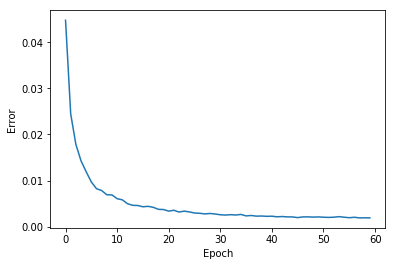

In [124]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

As a comment for the plot: the error function is not always smooth.

Unique users in our dataset:

In [125]:
grouped2.index

Int64Index([  1,   2,   4,   5,   7,   8,   9,  10,  13,  14,
            ...
            488, 489, 490, 491, 493, 495, 496, 497, 498, 499],
           dtype='int64', name='user_id', length=328)

Let's take some user_id's and recommend some items for them.

In [126]:
arr = vals[1].reshape(1, -1)
arr.size

2826

In [135]:
mock_user_id = 382 

#norm_user_rating_df.loc[mock_user_id]

#Selecting the input user
mock_user_data = norm_user_rating_df.loc[mock_user_id].values

inputUser = mock_user_data.reshape(1, -1) #vals[mock_user_id-1].reshape(1, -1)

#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

scored_products_df_mock = products[products['product_id'].isin(norm_user_rating_df.columns)]
scored_products_df_mock = scored_products_df_mock.assign(RecommendationScore = rec[0])

In [136]:
scored_products_df_mock.sort_values(["RecommendationScore"], ascending=False).head(40)

,product_id,product_name,aisle_id,department_id,RecommendationScore
24851,24852,Banana,24,4,0.040935
13175,13176,Bag of Organic Bananas,24,4,0.022255
47208,47209,Organic Hass Avocado,24,4,0.014806
47765,47766,Organic Avocado,24,4,0.013933
16796,16797,Strawberries,24,4,0.010914
39274,39275,Organic Blueberries,123,4,0.010430
26208,26209,Limes,24,4,0.010320
27844,27845,Organic Whole Milk,84,16,0.009317
22034,22035,Organic Whole String Cheese,21,16,0.009012
21136,21137,Organic Strawberries,24,4,0.008621


In [139]:
products_bought = df_merge[df_merge['user_id']==mock_user_id].sort_values(["product_id"])
products_bought_list = products_bought['product_id']
products_bought_df = pd.DataFrame(products[products['product_id'].isin(products_bought_list)])


In [140]:
products_bought_df

,product_id,product_name,aisle_id,department_id
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7
2779,2780,Diced Red Onions,83,4
4137,4138,Arancita Rossa,77,7
4941,4942,Vanilla Almond Breeze,91,16
10069,10070,Organic 1% Low Fat Milk,84,16
13165,13166,"Organic Milk Reduced Fat, 2% Milkfat",84,16
17705,17706,Organic Whole Grain Wheat English Muffins,93,3
20021,20022,Granulated White Cane Sugar,17,13
25889,25890,Boneless Skinless Chicken Breasts,49,12
28155,28156,Total 0% Nonfat Plain Greek Yogurt,120,16
